In [1]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import scipy.stats
import statsmodels.formula.api as smf
from matplotlib.cbook import boxplot_stats

%matplotlib inline

In [2]:
home_dir = '/home/despo/iballard/lags/'
sub_file = op.join(home_dir,
                  'cocaine_subjects.tsv')
label_df = pd.read_csv(sub_file,delimiter = '\t')
label_df['counter'] = 1
print(label_df.groupby('group').sum()['counter'])

label_df = label_df[label_df['exclusion'] != 1] ##exclude author-excluded subjects

group_map = {1.0:'control',
            2.0:'cocaine'}

label_df['group_label'] = [group_map[x] for x in label_df['group']]
print(label_df.groupby('group').sum()['counter'])


group
1.0    64
2.0    74
Name: counter, dtype: int64
group
1.0    46
2.0    62
Name: counter, dtype: int64


In [3]:
fig_dir = '/home/despo/iballard/dopa/lags/shell_analysis/cocaine/figs/'

In [4]:
##load masks
mask_dir = '/home/despo/iballard/dopa/lags/shell_analysis/cocaine'
mask_ids = {'nacc_3mm':0,
            'nacc_1':1,
            'nacc_2':2,
            'nacc_3':3}
masks = {}
for mask in mask_ids.keys():
    masks[mask] = nb.load(op.join(mask_dir,
                        mask + '.nii.gz')).get_fdata().astype(bool)
    
mask

'nacc_3'

In [5]:
lag_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/cocaine_data/lags/'
df = []
for sub in set(label_df['participant_id']):


    group = label_df.loc[label_df['participant_id'] == sub,'group_label'].values[0]

    lag_map = op.join(lag_dir,
                      sub,
                     sub + '__lagtimes.nii.gz')

    if op.exists(lag_map):
        lags = nb.load(lag_map).get_fdata()

        for mask in mask_ids.keys():

            mean= np.median(lags[masks[mask]])


            sub_df = pd.DataFrame({'sub':sub,
                                  'mask':mask,
                                  'lag':mean*1000,
                                   'group':group,
                                   'distance':mask_ids[mask]
                                  }, index = [0])
            df.append(sub_df)

df = pd.concat(df)

In [6]:
spike_thr = 1.0

motion_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/cocaine_data/fmriprep_reg'
motion_params = []
for sub in set(label_df['participant_id']):
    motion = op.join(motion_dir,
                    sub + '_task-rest_desc-confounds_regressors.tsv')
    
    if op.exists(motion):
        motion = pd.read_csv(motion,
                            delimiter = '\t')
        
        mean = np.mean(motion['framewise_displacement'])
        spikes = motion[motion['framewise_displacement'] > spike_thr].shape[0]

        sub_df = pd.DataFrame({'sub':sub,
                              'fwd':mean,
                              'spikes':spikes}, index = [0])
        motion_params.append(sub_df.copy())
    else:
        print(motion)
motion_params = pd.concat(motion_params)

/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/cocaine_data/fmriprep_reg/sub-046_task-rest_desc-confounds_regressors.tsv


In [7]:
df = pd.merge(df,
        motion_params)
df = df[df.spikes <=5]
len(set(df['sub']))
df['counter'] = 1
counter = df.groupby(['sub','group']).mean().reset_index()
counter.groupby('group').sum()['counter']

group
cocaine    40.0
control    39.0
Name: counter, dtype: float64

In [8]:
colors = ["#026c6d", "#f48888","#fcb7b7",'#efcbcb']
# Set your custom color palette
pal = sns.color_palette(colors)

/home/despoC/iballard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  


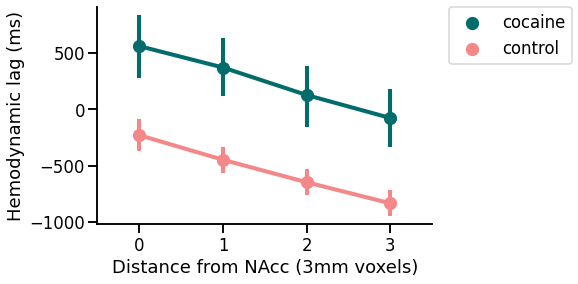

In [9]:
sns.set_context('talk')

sns.pointplot(x = 'distance',
             y = 'lag',
             ci = 68,
              hue = 'group',
              palette = pal,
             data = df)

sns.despine()
plt.ylabel('Hemodynamic lag (ms)')
plt.xlabel('Distance from NAcc (3mm voxels)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [10]:
df.to_csv('./cocaine_dfs/cocaine_shell_analysis.csv')


In [11]:
md = smf.mixedlm("lag ~ C(group, Treatment('control'))*distance", df, 
                 groups=df["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
======================================================================================================
Model:                           MixedLM                Dependent Variable:                lag        
No. Observations:                316                    Method:                            REML       
No. Groups:                      79                     Scale:                             170299.8322
Min. group size:                 4                      Log-Likelihood:                    -2467.2626 
Max. group size:                 4                      Converged:                         Yes        
Mean group size:                 4.0                                                                  
------------------------------------------------------------------------------------------------------
                                                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------------------------
Intercept                                             -238.196  196.165 -1.214 0.225 -622.672  146.280
C(group, Treatment('control'))[T.cocaine]              805.422  275.679  2.922 0.003  265.101 1345.744
distance                                              -200.965   29.552 -6.800 0.000 -258.886 -143.043
C(group, Treatment('control'))[T.cocaine]:distance     -14.484   41.531 -0.349 0.727  -95.884   66.915
Group Var                                          1381532.199  640.834                               
======================================================================================================

"""

In [12]:
##load masks
mask_dir = '/home/despo/iballard/dopa/lags/shell_analysis/cocaine/'
mask_ids = ['nacc_3mm',
            'putamen_3mm',
            'caudate_3mm',
            'striatum_3mm',
           'S1_3mm',
           'OT_3mm']
masks = {}
for mask in mask_ids:
    masks[mask] = nb.load(op.join(mask_dir,
                        mask + '.nii.gz')).get_fdata().astype(bool)
    

In [13]:
lag_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/cocaine_data/lags/'
df = []
for sub in set(label_df['participant_id']):


    group = label_df.loc[label_df['participant_id'] == sub,'group_label'].values[0]

    lag_map = op.join(lag_dir,
                      sub,
                     sub + '__lagtimes.nii.gz')

    if op.exists(lag_map):
        lags = nb.load(lag_map).get_fdata()

        for mask in mask_ids:

            median= np.median(lags[masks[mask]])


            sub_df = pd.DataFrame({'sub':sub,
                                  'mask':mask.split('_')[0],
                                  'lag':median*1000,
                                   'group':group,
                                  }, index = [0])
            df.append(sub_df)

df = pd.concat(df)

In [14]:
df = pd.merge(df,
        motion_params)
df.to_csv('./cocaine_dfs/region_comparison_median.csv')

df = df[df.spikes <=5]
len(set(df['sub']))

79

/home/despoC/iballard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  # Remove the CWD from sys.path while we load stuff.


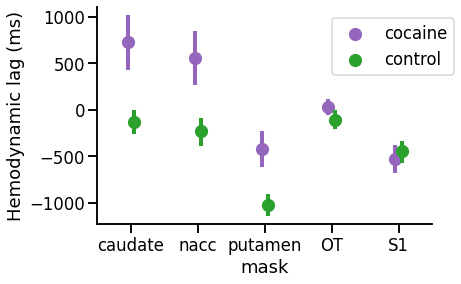

In [14]:
sns.set_context('talk')
sns.pointplot(x = 'mask',
             y = 'lag',
             ci = 68,
              order = ['caudate','nacc','putamen','OT','S1'],
              hue = 'group',
             join = False,
                   palette = [sns.color_palette()[4],sns.color_palette()[2]],
              dodge = .1,
             data = df)
sns.despine()
plt.ylabel('Hemodynamic lag (ms)')
plt.legend(bbox_to_anchor=(.7, .95), loc='upper left', borderaxespad=0)
plt.savefig(op.join(fig_dir,
                   'lag_cocaine.png'),
            bbox_inches = 'tight',
            dpi = 300)

In [15]:
sub_df = df[df['mask'].isin(['S1','nacc'])]
md = smf.mixedlm("lag ~ C(group, Treatment('control'))*C(mask,Treatment('nacc'))", sub_df, 
                 groups=sub_df["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Mixed Linear Model Regression Results
==============================================================================================================================
Model:                                    MixedLM                       Dependent Variable:                       lag         
No. Observations:                         158                           Method:                                   REML        
No. Groups:                               79                            Scale:                                    1041949.1191
Min. group size:                          2                             Log-Likelihood:                           -1302.1039  
Max. group size:                          2                             Converged:                                Yes         
Mean group size:                          2.0                                                                                 
------------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    -229.988  174.230 -1.320 0.187  -571.473  111.497
C(group, Treatment('control'))[T.cocaine]                                     789.031  244.854  3.222 0.001   309.126 1268.935
C(mask, Treatment('nacc'))[T.S1]                                             -216.584  231.156 -0.937 0.349  -669.642  236.475
C(group, Treatment('control'))[T.cocaine]:C(mask, Treatment('nacc'))[T.S1]   -870.899  324.855 -2.681 0.007 -1507.603 -234.195
Group Var                                                                  141940.497  148.021                                
==============================================================================================================================

"""

## classifier

In [15]:
##load masks
mask_dir = '/home/despo/iballard/dopa/lags/shell_analysis/cocaine'
mask_ids = ['striatum_3mm']
masks = {}
for mask in mask_ids:
    masks[mask] = nb.load(op.join(mask_dir,
                        mask + '.nii.gz')).get_fdata().astype(bool)
    
mask

'striatum_3mm'

In [16]:
lag_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/cocaine_data/lags/'
df = []
for sub in set(label_df['participant_id']):


    group = label_df.loc[label_df['participant_id'] == sub,'group_label'].values[0]

    lag_map = op.join(lag_dir,
                      sub,
                     sub + '__lagtimes.nii.gz')

    if op.exists(lag_map):
        lags = nb.load(lag_map).get_fdata()

        for mask in mask_ids:

            mask_data= lags[masks[mask]]


            sub_df = pd.DataFrame({'sub':[sub]*len(mask_data),
                                  'mask':[mask]*len(mask_data),
                                  'lag':mask_data,
                                   'voxel':np.arange(len(mask_data)),
                                   'group':[group]*len(mask_data),
                                  })
            df.append(sub_df)

df = pd.concat(df)

In [17]:
df = pd.merge(df,
        motion_params)
df.to_csv('./striatal_classifier_data.csv')

In [18]:
spike_threshold = 5
df = df[df.spikes <=spike_threshold]
len(set(df['sub']))

104
{'sub-044', 'sub-025', 'sub-008', 'sub-014', 'sub-072', 'sub-083', 'sub-010', 'sub-074', 'sub-022', 'sub-043', 'sub-047', 'sub-142', 'sub-077', 'sub-103', 'sub-028', 'sub-115', 'sub-109', 'sub-067', 'sub-073', 'sub-058', 'sub-060', 'sub-116', 'sub-061', 'sub-075', 'sub-057'}
{6, 7, 8, 9, 10, 43, 12, 13, 14, 15, 79, 25, 28, 29, 31}


79

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = pd.pivot_table(df, values='lag',
                         index='sub',
                         columns='voxel')

y_map = {'cocaine':1,'control':0}
y = X.index
y = df.groupby(['sub','group']).mean().reset_index().set_index('sub').loc[y,'group'].values
y = np.array([y_map[n] for n in y])

X = np.array(X)

X = X - X.mean(1, keepdims=True)

In [20]:
from sklearn.model_selection import LeaveOneOut
scores = []

loo = LeaveOneOut()
for train, test in loo.split(X):

    X_train = X[train]

    scaler = StandardScaler()

    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X[test])

    clf = LogisticRegression(penalty = 'l1',
                            solver='liblinear').fit(X_train, y[train])
    scores.append(clf.score(X_test, y[test]))

classifier_performance = np.mean(scores)

classifier_performance

0.6708860759493671

/home/despoC/iballard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  


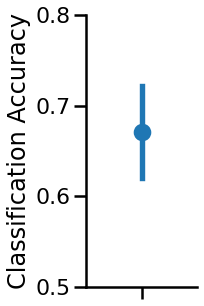

In [21]:
sns.set_context('poster')

plt.figure(figsize=(2,5))

s = pd.DataFrame({'scores':scores})
sns.pointplot(y = 'scores',
              ci = 68, 
              data = s)
plt.ylim(.5,.8)
plt.ylabel('Classification Accuracy')
sns.despine()
plt.savefig(op.join(fig_dir,
                   'classification.png'),
            bbox_inches = 'tight',
            dpi = 300)

In [1]:
scaler = StandardScaler()
X_mod = scaler.fit_transform(X)
mod = clf.fit(X_mod,y)
probs = mod.predict_log_proba(X_mod)[:,1]

prob_df = df.groupby('sub').mean().reset_index()
prob_df['logprob'] = probs

label_df['sub'] = label_df['participant_id']

merged = pd.merge(label_df,
        prob_df,
        on = ['sub'])




var = 'tobc.day' 
sub_df = merged[merged['group_label'] == 'cocaine'].dropna(subset = ['logprob',var])

sns.scatterplot(x =  'logprob',
          y = var,
#            ci = 68,
          data = sub_df)
plt.ylabel('Daily Tobacco Use')
plt.xlabel('Log probability of \ncocaine group membership')

scipy.stats.spearmanr(sub_df['logprob'],
                     sub_df[var])

In [31]:
scipy.stats.spearmanr(sub_df['logprob'],
                     sub_df[var])
scipy.stats.spearmanr(sub_df['week.dose'],
                     sub_df['tobc.day'])

SpearmanrResult(correlation=0.020854589981249123, pvalue=0.9039092168107974)

## Compute voxelwise preference model

In [113]:
def compute_prefs(model, X,y, cov=None):
    """Invert the decoding model to get voxel preferences."""
    if cov is None:
        cov = np.cov(X.T)
    weights = model.fit(X, y).coef_.squeeze()
    return cov.dot(weights)

In [2]:
scaler = StandardScaler()
X_mod = scaler.fit_transform(X)
cov = np.cov(X_mod.T)
clf = LogisticRegression(random_state=20, 
                         penalty = 'l1',
                        solver='liblinear')
voxel_prefs = compute_prefs(clf,X_mod,y)

#null distribution
null = []
null_prefs = []
y_shuffle = np.array(y)

for n in range(1000):
    
    
    np.random.shuffle(y_shuffle)
    
    #get preferences
    clf = LogisticRegression(penalty = 'l1',
                            solver='liblinear')
    n_prefs = compute_prefs(clf,X_mod,y_shuffle,cov)
    null_prefs.append(n_prefs)
    
    #get cross-validated score
    scores = []
    loo = LeaveOneOut()
    for train, test in loo.split(X):

        X_train = X[train]
    
        scaler = StandardScaler()

        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X[test])

        clf = LogisticRegression(penalty = 'l1',
                                solver='liblinear').fit(X_train, y_shuffle[train])
        scores.append(clf.score(X_test, y_shuffle[test]))
    
    null.append(np.mean(scores))
null_prefs = np.array(null_prefs)

In [51]:
np.savetxt('./cocaine_dfs/null_prefs.csv',null_prefs)
np.savetxt('./cocaine_dfs/loo_scores.csv',scores)
np.savetxt('./cocaine_dfs/null_distribution.csv',null)


In [115]:
mask = 'striatum_3mm'
striatum_mask = nb.load(op.join(mask_dir,
                        mask + '.nii.gz')).get_fdata().astype(bool)
x,y,z= np.indices(striatum.shape)



x_loc = x[striatum_mask]

x_loc = [abs(n - round(x.shape[0]/2)) for n in x_loc] #recode to medial->lateral

y_loc = y[striatum_mask]
z_loc = z[striatum_mask]

loc_df = pd.DataFrame({'x':np.array(x_loc)*3,
                      'y':np.array(y_loc)*3,
                      'z':np.array(z_loc)*3,
                      'prefs':voxel_prefs})
loc_df.to_csv('./cocaine_dfs/loc_df.csv')


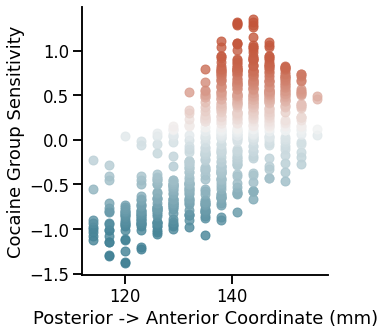

In [31]:
sns.set_context('talk')
ax = sns.lmplot(x = 'y',
          y = 'prefs',
           hue = 'prefs',
           palette = sns.diverging_palette(220, 20, n = len(set(loc_df['prefs']))),
           aspect = 1,
           legend = False,
          data = loc_df)



plt.ylabel('Cocaine Group Sensitivity')
plt.xlabel('Posterior -> Anterior Coordinate (mm)')
plt.savefig(op.join(fig_dir,
                   'cocaine_pref_y.png'),
            bbox_inches = 'tight',
            dpi = 300)



In [116]:
for var in ['x','y','z']:
    loc_df[var] = loc_df[var] - np.mean(loc_df[var])
    loc_df[var] = loc_df[var] / np.std(loc_df[var])

In [117]:
null_coefficients = []
for i in range(null_prefs.shape[0]):
    null_loc_df = loc_df.copy()

    null_loc_df['null_pref'] = null_prefs[i,:]
    
    md = smf.ols("null_pref ~ x+ y + z", 
             null_loc_df).fit()
    
    #save coefficiencts
    coeff = pd.DataFrame(md.params).reset_index()
    coeff = coeff.rename(columns = {'index':'param',
                           0:'value'})
    coeff['index'] = i
    coeff = coeff.pivot(columns = 'param',
                values = 'value',
                index = 'index')

    null_coefficients.append(coeff.copy())
null_coefficients = pd.concat(null_coefficients)

/home/despoC/iballard/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


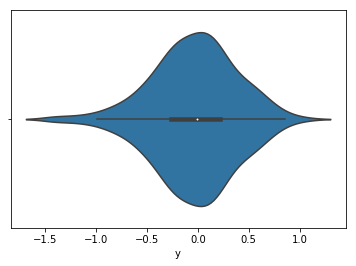

In [29]:
sns.violinplot(null_coefficients['y'])

In [121]:
md = smf.ols("prefs ~ x + y + z", 
            loc_df).fit()
md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  prefs   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     276.6
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          1.14e-120
Time:                        17:54:46   Log-Likelihood:                -407.29
No. Observations:                 750   AIC:                             822.6
Df Residuals:                     746   BIC:                             841.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0376      0.015      2.466      0.014       0.008       0.068
x             -0.0204      0.020     -1.030      0.303      -0.059       0.018
y              0.4329      0.020     21.480      0.000       0.393       0.472
z              0.0955      0.016      6.058      0.000       0.065       0.126
==============================================================================
Omnibus:                        4.649   Durbin-Watson:                   0.855
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                4.690
Skew:                           0.174   Prob(JB):                       0.0959
Kurtosis:                       2.831   Cond. No.                         2.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
for var in ['x','y','z']:
    
    print(var, sum(md.params[var] < null_coefficients[var]) / null_coefficients.shape[0])

x 0.558
y 0.027
z 0.204
